# Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import os
from movenet import Movenet
import wget
import csv
import tqdm 
from data import BodyPart

In [2]:
import mediapipe as mp

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mpHands = mp.solutions.hands

In [4]:
from mediapipe.python.solutions.pose import Pose

In [5]:
if('movenet_thunder.tflite' not in os.listdir()):
    wget.download('https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite', 'movenet_thunder.tflite')

movenet = Movenet('movenet_thunder')


In [6]:
def detect(input_tensor, inference_count=3):
    movenet.detect(input_tensor.numpy(), reset_crop_region=True)
    
    for _ in range(inference_count - 1):
        detection = movenet.detect(input_tensor.numpy(), 
                                reset_crop_region=False)
    
    return detection

In [7]:
class Preprocessor(object):
#     this class preprocess pose samples, it predicts keypoints on the images 
#     and save those keypoints in a csv file for the later use in the classification task 

        def __init__(self, images_in_folder,
                    csvs_out_path):
            self._images_in_folder = images_in_folder
            self._csvs_out_path = csvs_out_path
            self._csvs_out_folder_per_class = 'csv_per_pose'
            self._message = []
            
            if(self._csvs_out_folder_per_class not in os.listdir()):
                os.makedirs(self._csvs_out_folder_per_class)
            
#             get list of pose classes
            self._pose_class_names = sorted(
                [n for n in os.listdir(images_in_folder)]
            )
    

In [8]:

def process(self, detection_threshold=0.1):
#             Preprocess the images in the given folder
    for pose_class_name in self._pose_class_names:
#                 paths for pose class
        images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
        csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                       pose_class_name + '.csv'
                                   )
#               Detect landmarks in each images and write it to the csv files
        with open(csv_out_path, 'w') as csv_out_file:
            csv_out_writer = csv.writer(csv_out_file,
                                        delimiter=',',
                                        quoting=csv.QUOTE_MINIMAL
                                       )
#             get the list of images
            image_names = sorted(
                [n for n in os.listdir(images_in_folder)]
            )
            valid_image_count = 0
            # Detect pose landmarks in each image
            for image_name in tqdm.tqdm(image_names):
                image_path = os.path.join(images_in_folder, image_name)

                try:
                    image = tf.io.read_file(image_path)
                    image = tf.io.decode_jpeg(image)
                except:
                    self._message.append('Skipped' + image_path + ' Invalid image')
                    continue

                # skip images that is not RGB
                if image.shape[2] != 3:
                    self.message.append('Skipped' + image_path + ' Image is not in RGB')
                    continue

                person = detect(image)

                # Save landmarks if all landmarks above than the threshold
                min_landmark_score = min([keypoint.score for keypoint in person.keypoints])
                should_keep_image = min_landmark_score >= detection_threshold
                if not should_keep_image:
                    self._message.append('Skipped' + image_path + 'Keypoints score are below than threshold')
                    continue

                valid_image_count += 1

                # Get landmarks and scale it to the same size as the input image
                pose_landmarks = np.array(
                      [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                        for keypoint in person.keypoints],
                          dtype=np.float32)

                # writing the landmark coordinates to its csv files
                coord = pose_landmarks.flatten().astype(np.str).tolist()
                csv_out_writer.writerow([image_name] + coord)

    print(self._message)

    # combine all per-csv class CSVs into a sigle csv file
    all_landmarks_df = self.all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)


In [9]:
def class_names(self):
    return self.pose_class_names

def all_landmarks_as_dataframe(self):
    # Merging all csv for each class into a single csv file
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
        csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                       class_name + '.csv'
                                   )
        per_class_df = pd.read_csv(csv_out_path, header=None)

        # Add the labels
        per_class_df['class_no'] = [class_index]*len(per_class_df)
        per_class_df['class_name'] = [class_name]*len(per_class_df)

        # Append the folder name to the filename first column
        per_class_df[per_class_df.columns[0]] = class_name + '/' +  per_class_df[per_class_df.columns[0]]

        if total_df is None:
            total_df = per_class_df
        else:
            total_df = pd.concat([total_df, per_class_df], axis=0)

    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
          bodypart.name + '_score'] for bodypart in BodyPart]

    header_name = []
    for columns_name in list_name:
        header_name += columns_name
    header_name = ['filename'] + header_name
    header_map = { total_df.columns[i]: header_name[i]
                     for i in range(len(header_name))
                 }

    total_df.rename(header_map, axis=1, inplace=True)

    return total_df


# class

In [10]:
class Preprocessor(object):
#     this class preprocess pose samples, it predicts keypoints on the images 
#     and save those keypoints in a csv file for the later use in the classification task 

        def __init__(self, images_in_folder,
                    csvs_out_path):
            self._images_in_folder = images_in_folder
            self._csvs_out_path = csvs_out_path
            self._csvs_out_folder_per_class = 'csv_per_pose'
            self._message = []
            
            if(self._csvs_out_folder_per_class not in os.listdir()):
                os.makedirs(self._csvs_out_folder_per_class)
            
#             get list of pose classes
            self._pose_class_names = sorted(
                [n for n in os.listdir(images_in_folder)]
            )
    

        
        def process(self, detection_threshold=0.1):
#             Preprocess the images in the given folder
            for pose_class_name in self._pose_class_names:
#                 paths for pose class
                images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
                csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                               pose_class_name + '.csv'
                                           )
#               Detect landmarks in each images and write it to the csv files
                with open(csv_out_path, 'w') as csv_out_file:
                    csv_out_writer = csv.writer(csv_out_file,
                                                delimiter=',',
                                                quoting=csv.QUOTE_MINIMAL
                                               )
    #             get the list of images
                    image_names = sorted(
                        [n for n in os.listdir(images_in_folder)]
                    )
                    valid_image_count = 0
                    # Detect pose landmarks in each image
                    for image_name in tqdm.tqdm(image_names):
                        image_path = os.path.join(images_in_folder, image_name)
                        
                        try:
                            image = tf.io.read_file(image_path)
                            image = tf.io.decode_jpeg(image)
                        except:
                            self._message.append('Skipped' + image_path + ' Invalid image')
                            continue
                        
                        # skip images that is not RGB
                        if image.shape[2] != 3:
                            self.message.append('Skipped' + image_path + ' Image is not in RGB')
                            continue
                        
                        person = detect(image)
                        
                        # Save landmarks if all landmarks above than the threshold
                        min_landmark_score = min([keypoint.score for keypoint in person.keypoints])
                        should_keep_image = min_landmark_score >= detection_threshold
                        if not should_keep_image:
                            self._message.append('Skipped' + image_path + 'Keypoints score are below than threshold')
                            continue
                            
                        valid_image_count += 1
                        
                        # Get landmarks and scale it to the same size as the input image
                        pose_landmarks = np.array(
                              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                                for keypoint in person.keypoints],
                                  dtype=np.float32)
                        
                        # writing the landmark coordinates to its csv files
                        coord = pose_landmarks.flatten().astype(np.str).tolist()
                        csv_out_writer.writerow([image_name] + coord)
                        
            print(self._message)

            # combine all per-csv class CSVs into a sigle csv file
            all_landmarks_df = self.all_landmarks_as_dataframe()
            all_landmarks_df.to_csv(self._csvs_out_path, index=False)

        def class_names(self):
            return self.pose_class_names
        
        def all_landmarks_as_dataframe(self):
            # Merging all csv for each class into a single csv file
            total_df = None
            for class_index, class_name in enumerate(self._pose_class_names):
                csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                               class_name + '.csv'
                                           )
                per_class_df = pd.read_csv(csv_out_path, header=None)
                
                # Add the labels
                per_class_df['class_no'] = [class_index]*len(per_class_df)
                per_class_df['class_name'] = [class_name]*len(per_class_df)
                
                # Append the folder name to the filename first column
                per_class_df[per_class_df.columns[0]] = class_name + '/' +  per_class_df[per_class_df.columns[0]]
                
                if total_df is None:
                    total_df = per_class_df
                else:
                    total_df = pd.concat([total_df, per_class_df], axis=0)
            
            list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart]
            
            header_name = []
            for columns_name in list_name:
                header_name += columns_name
            header_name = ['filename'] + header_name
            header_map = { total_df.columns[i]: header_name[i]
                             for i in range(len(header_name))
                         }
            
            total_df.rename(header_map, axis=1, inplace=True)
            
            return total_df



In [11]:
# preprocess training data
images_in_folder = os.path.join('work_outs', 'train')
csvs_out_path = 'train_data.csv'
train_preprocessor = Preprocessor(
    images_in_folder,
    csvs_out_path
)
train_preprocessor.process()  

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]C:\Users\ajarir\AppData\Local\Temp\ipykernel_4852\3260207476.py:75: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coord = pose_landmarks.flatten().astype(np.str).tolist()
  1%|▍                                                                               | 11/2000 [00:18<55:52,  1.69s/it]C:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\ProgramData\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double

['Skippedwork_outs\\train\\curls\\cur1003.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\train\\curls\\cur1004.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\train\\curls\\cur1008.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\train\\curls\\cur1009.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\train\\curls\\cur1013.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\train\\curls\\cur1014.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\train\\curls\\cur1018.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\train\\curls\\cur1019.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\train\\curls\\cur1023.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\train\\curls\\cur1024.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\train\\curls\\cur1027.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\train\\curls\\cur1028.j

In [12]:
# preprocess training data
images_in_folder = os.path.join('work_outs', 'test')
csvs_out_path = 'test_data.csv'
train_preprocessor = Preprocessor(
    images_in_folder,
    csvs_out_path
)
train_preprocessor.process()  

  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]C:\Users\ajarir\AppData\Local\Temp\ipykernel_4852\3260207476.py:75: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coord = pose_landmarks.flatten().astype(np.str).tolist()
  0%|                                                                                 | 2/2000 [00:00<01:56, 17.09it/s]C:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\ProgramData\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double

['Skippedwork_outs\\test\\curls\\curls273.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\test\\curls\\curls274.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\test\\curls\\curls277.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\test\\curls\\curls278.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\test\\curls\\curls279.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\test\\curls\\curls283.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\test\\curls\\curls284.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\test\\curls\\curls288.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\test\\curls\\curls289.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\test\\curls\\curls293.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\test\\curls\\curls294.jpgKeypoints score are below than threshold', 'Skippedwork_outs\\test\\curls\\curls298.j

}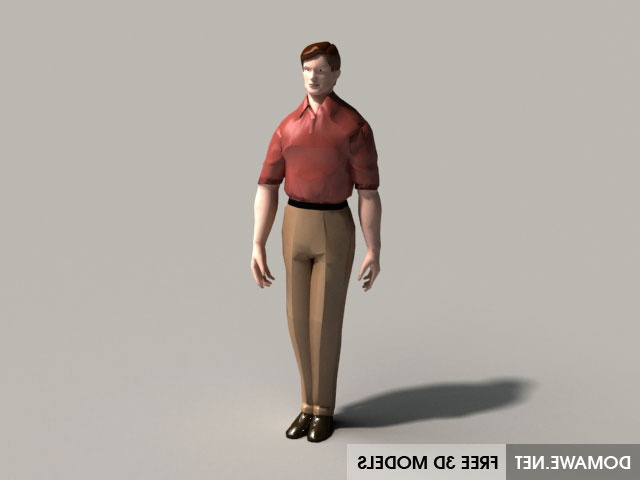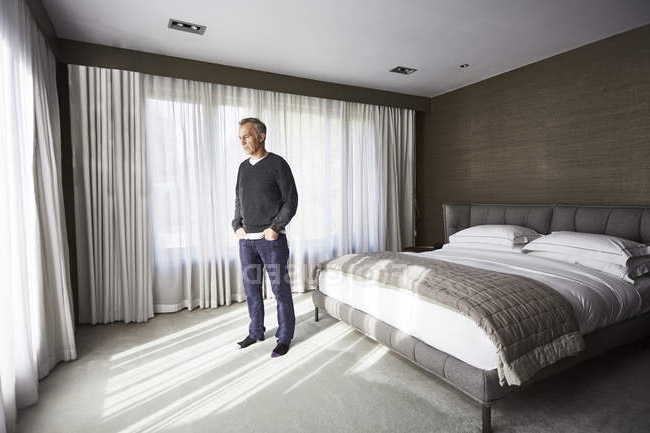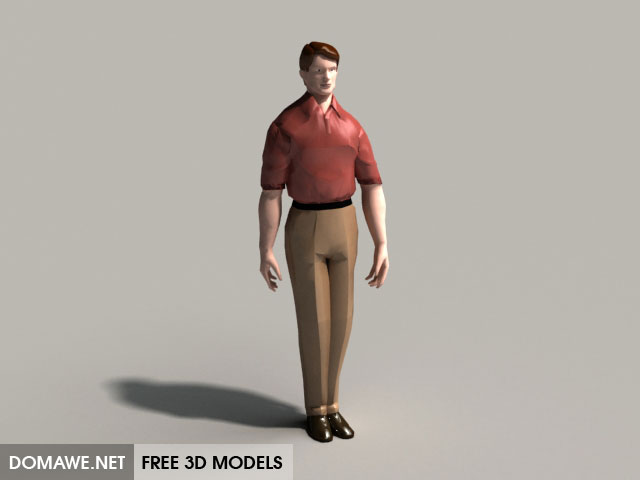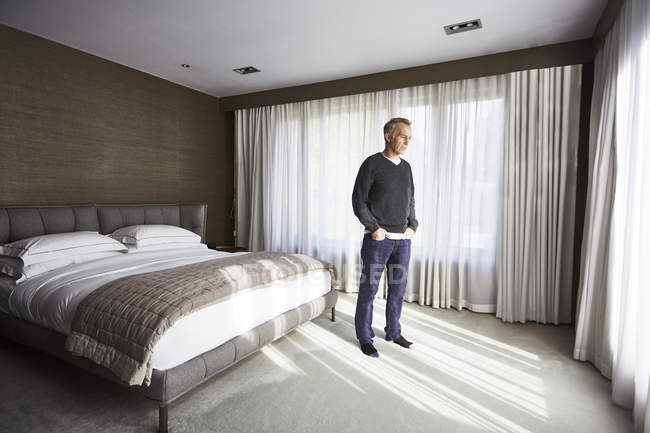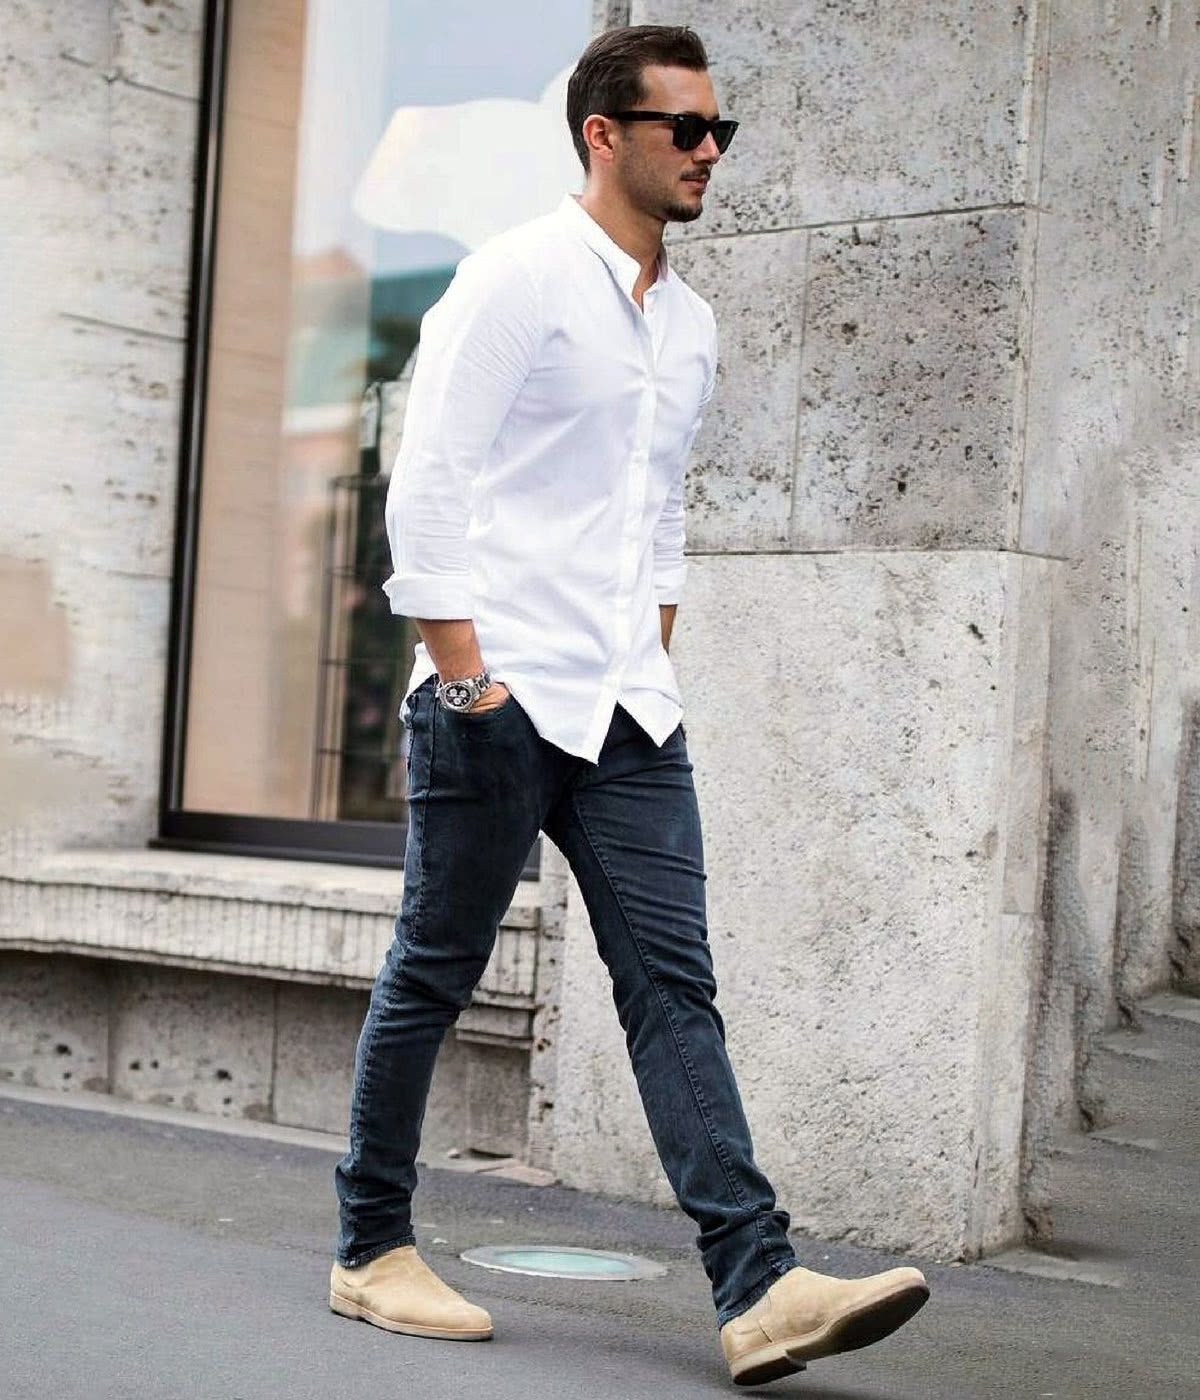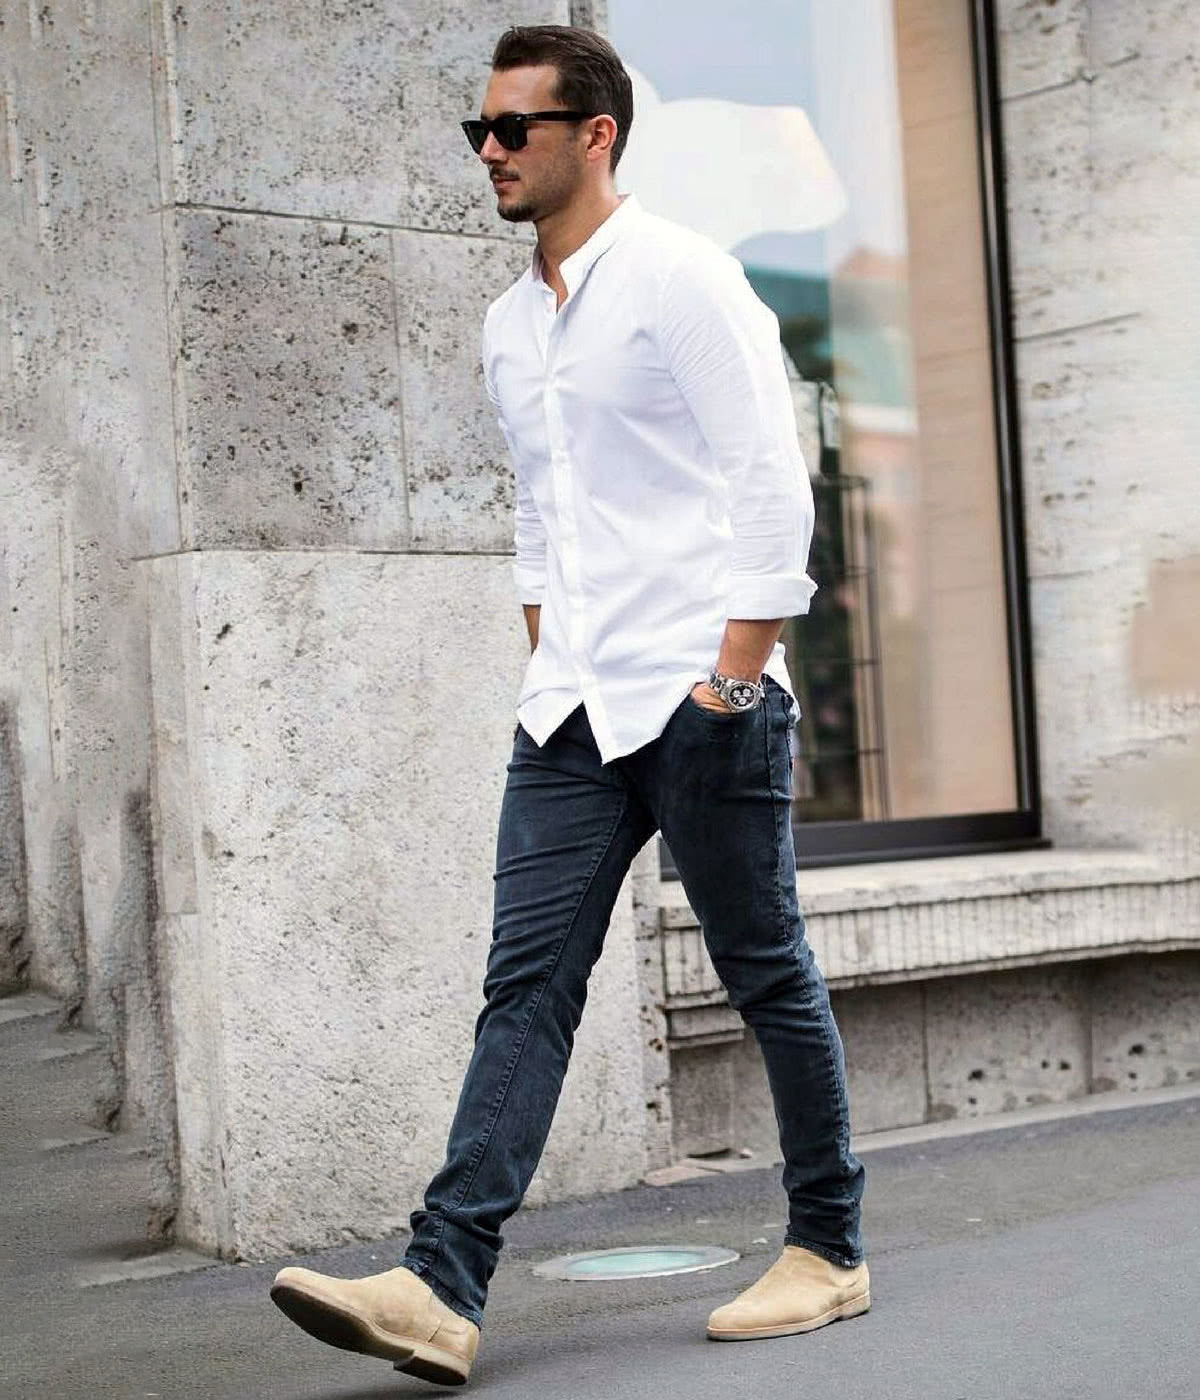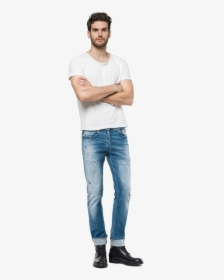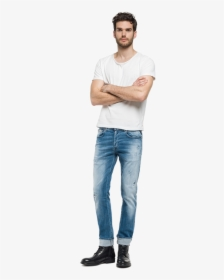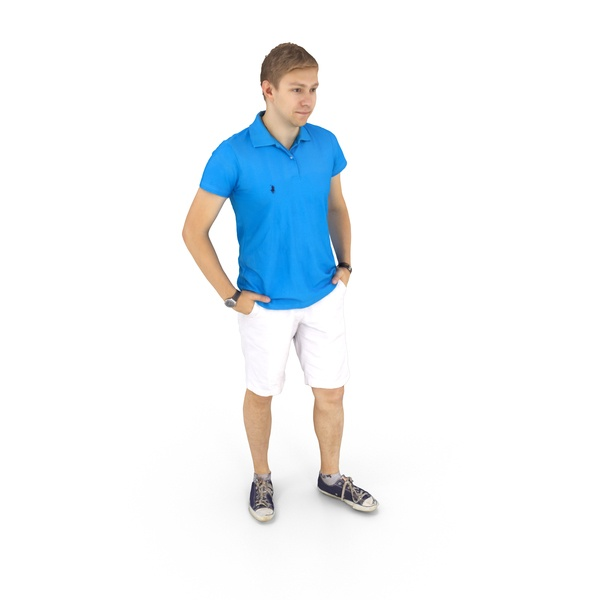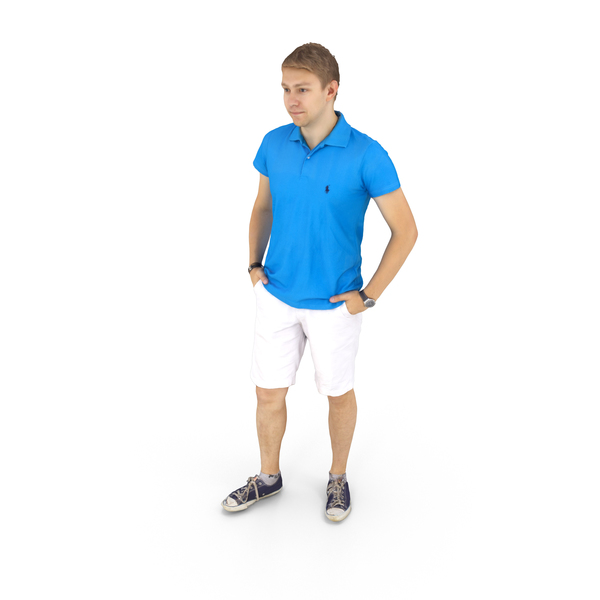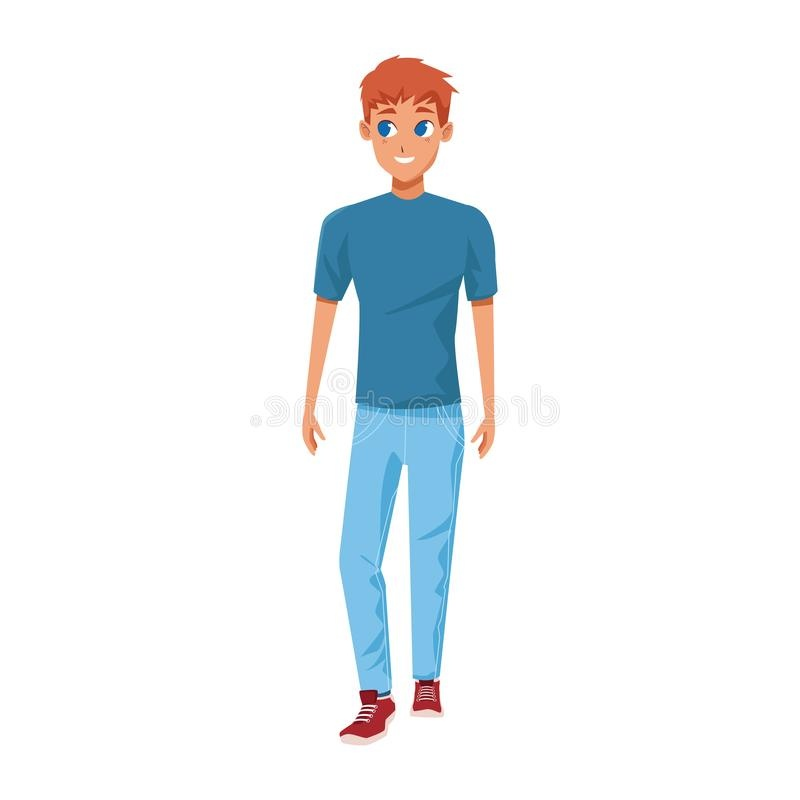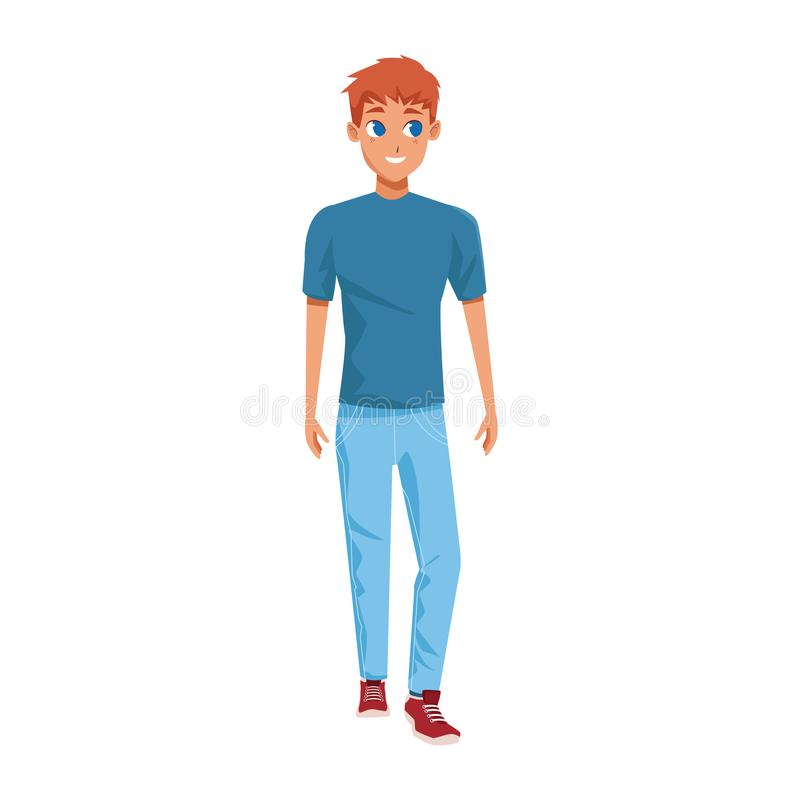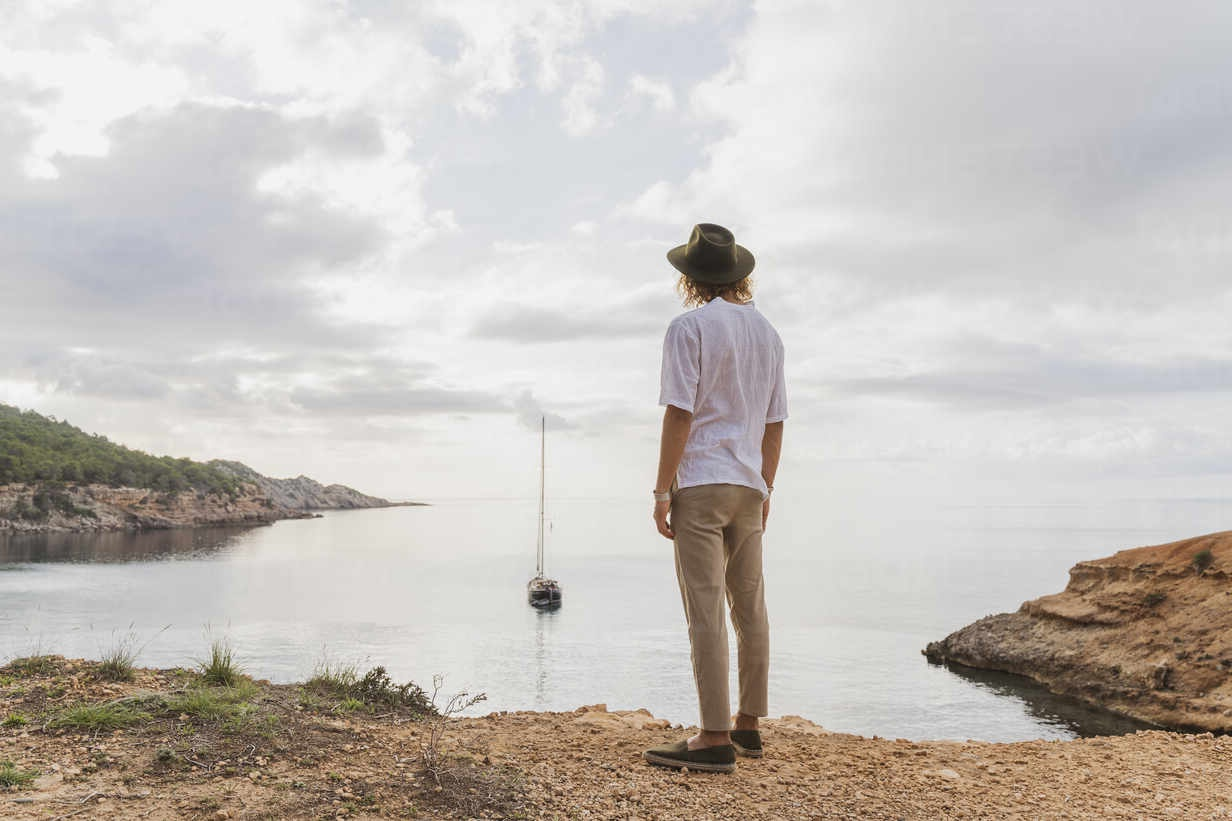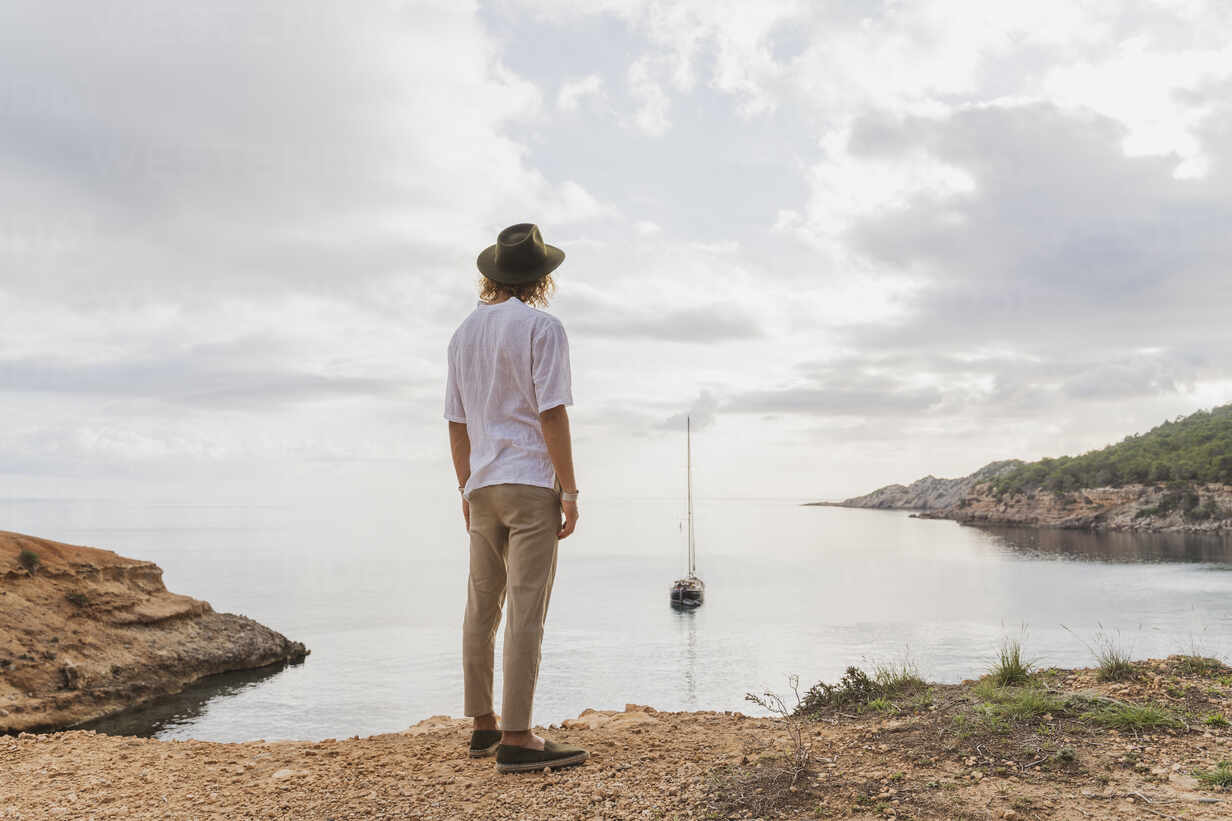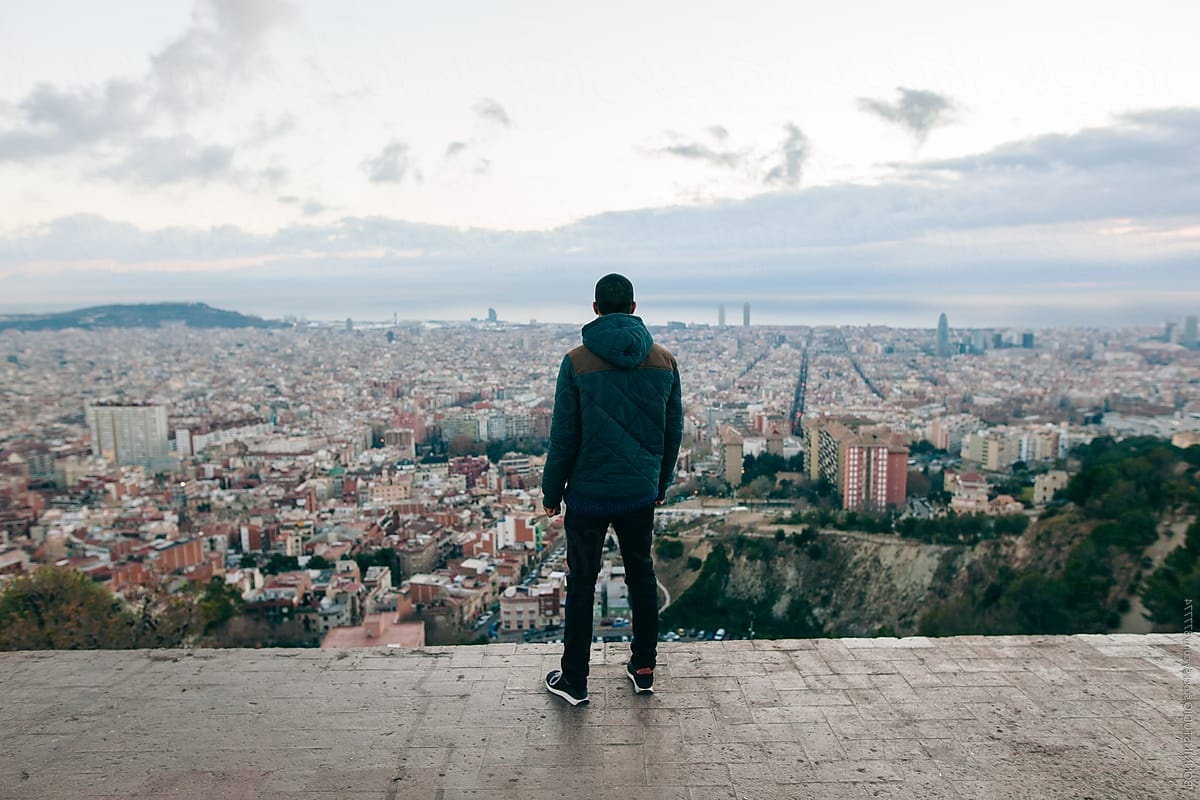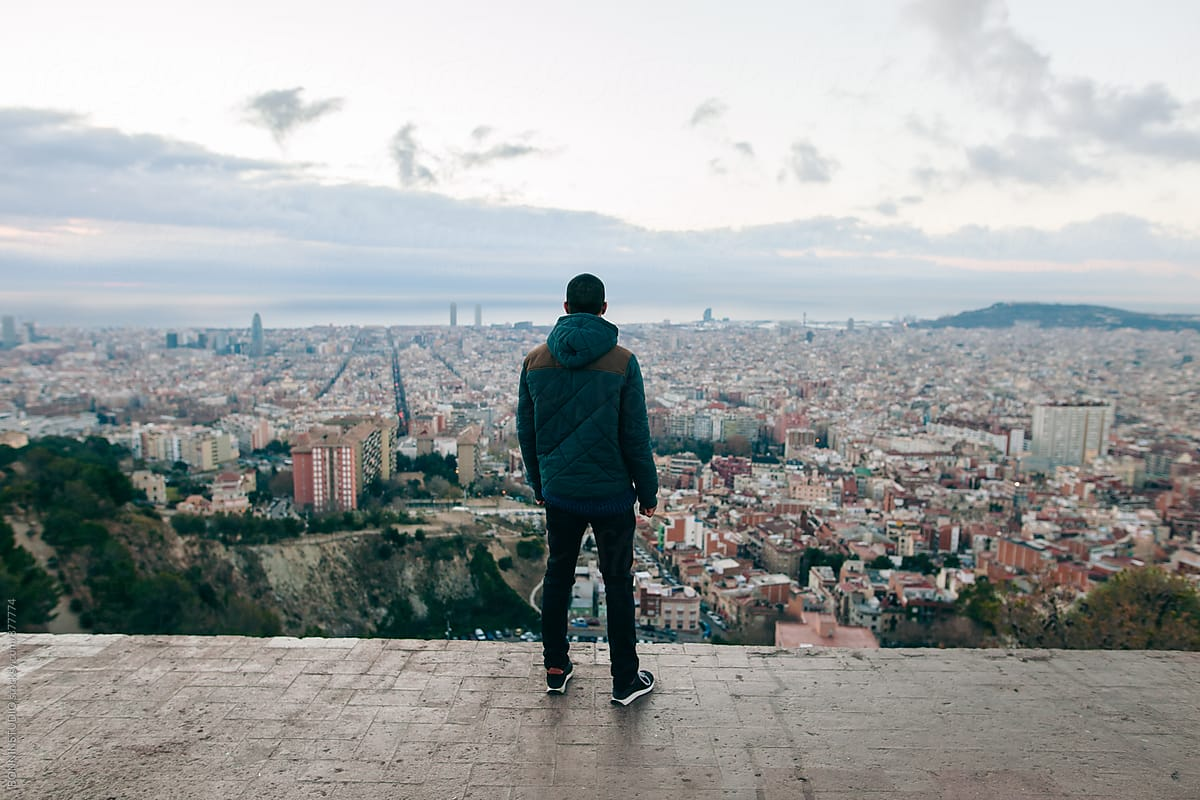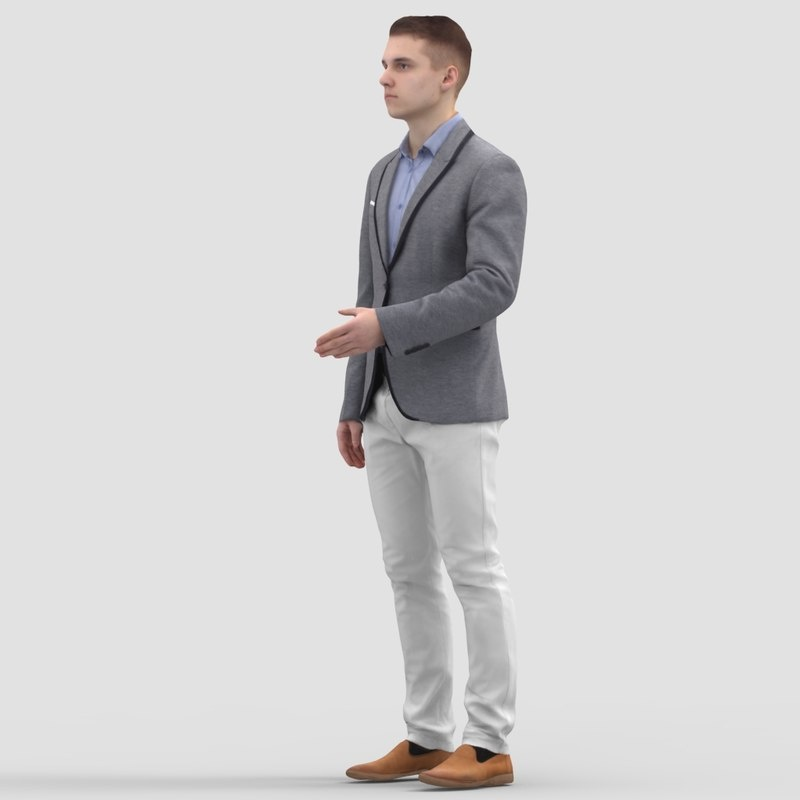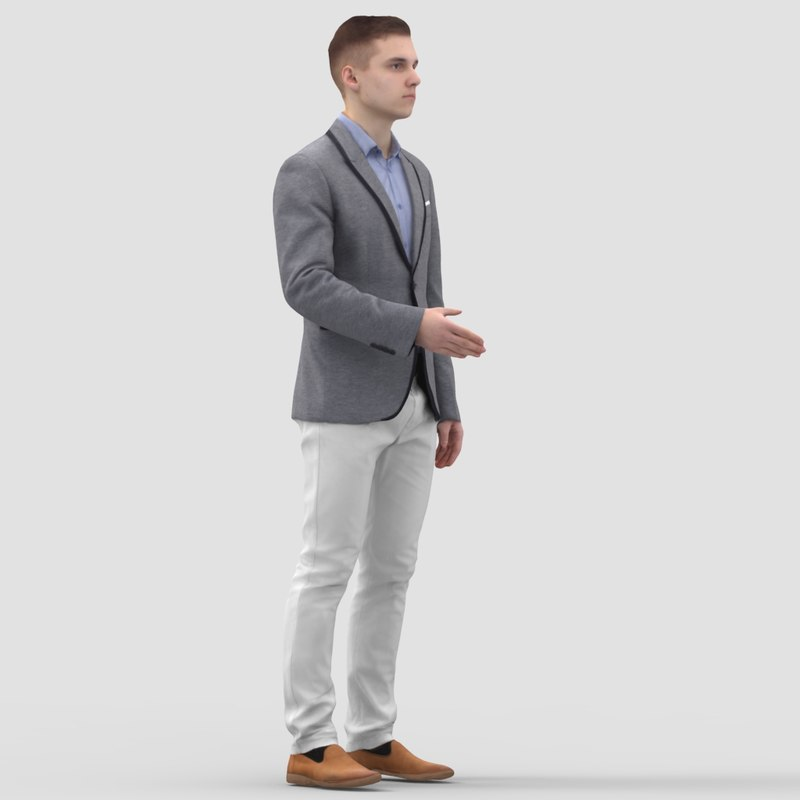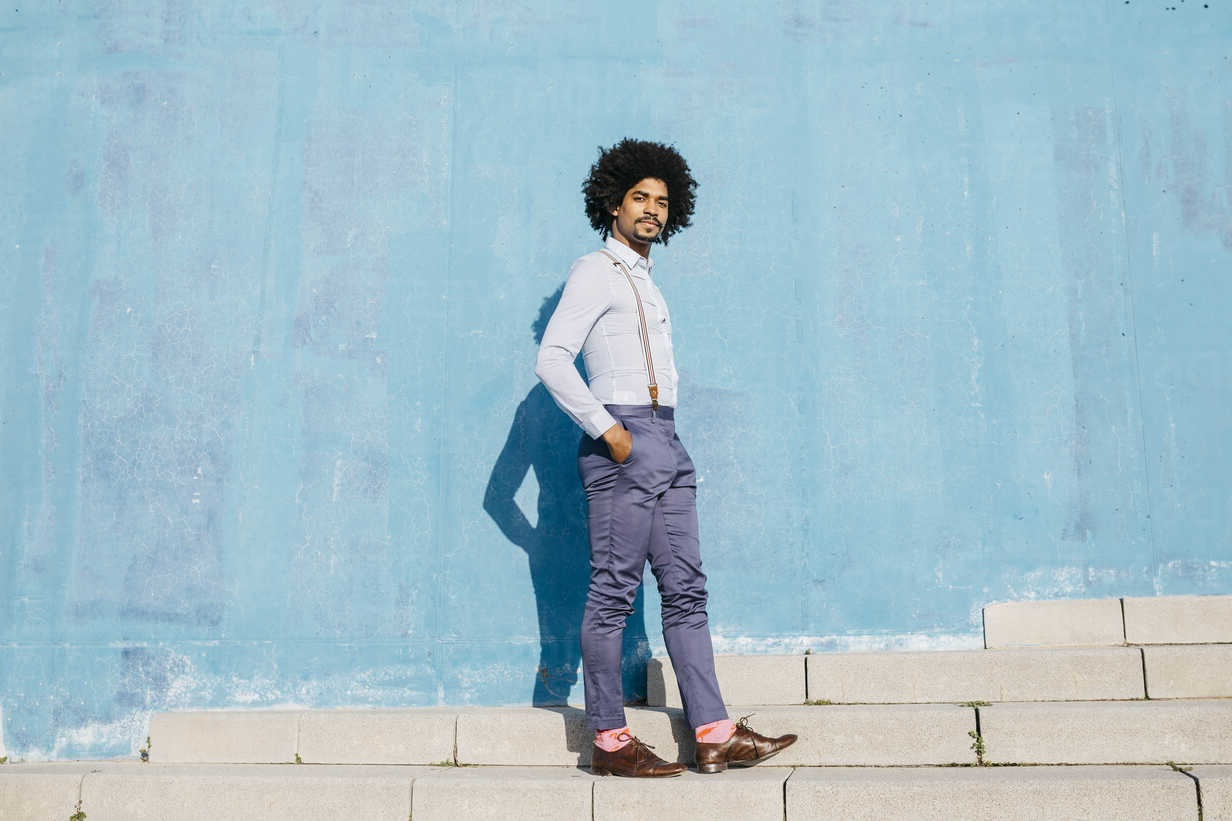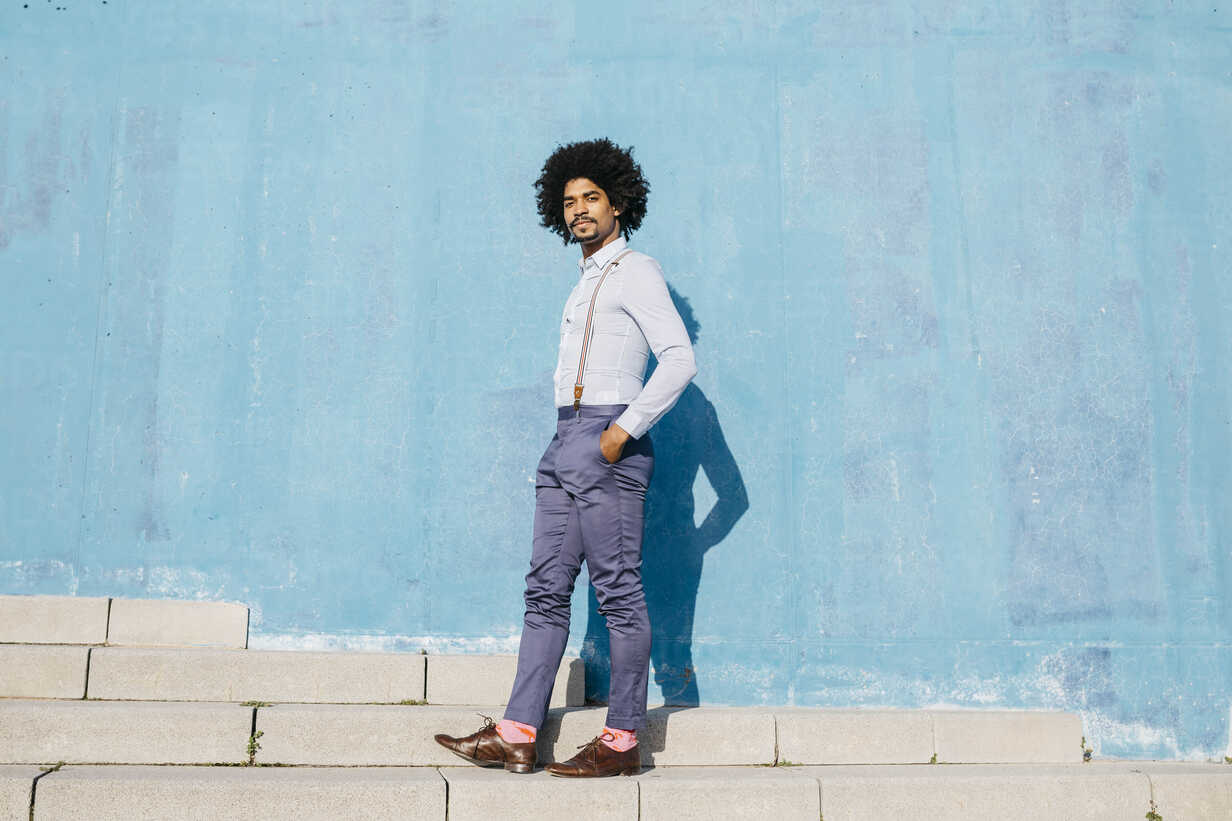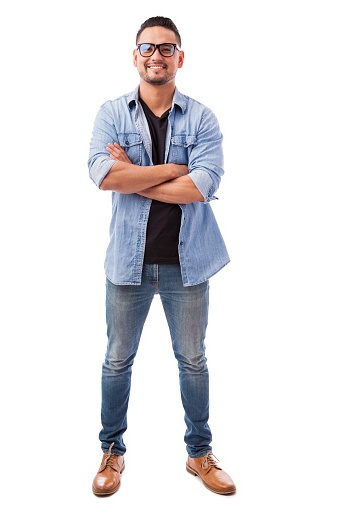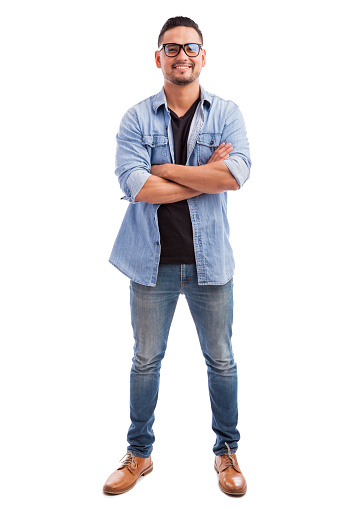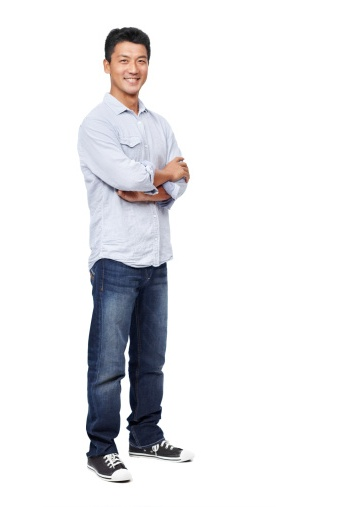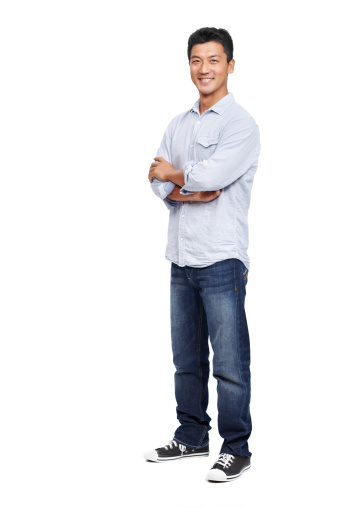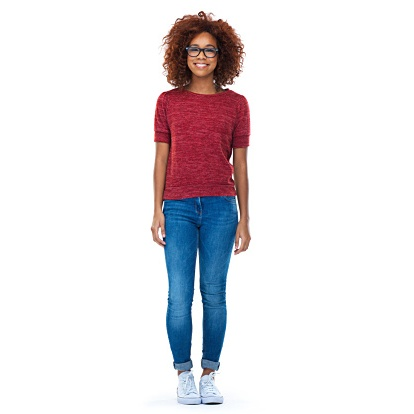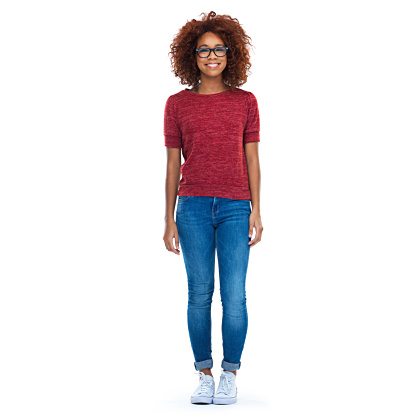+~{/-p0o9i#### 